In [12]:
import mne
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs


# 设置编码为 'latin1'
raw = mne.io.read_raw_edf('糖尿病认知障碍与对照脑电数据/认知障碍/陈艳杰.edf', preload=True, encoding='latin1')
import warnings
raw.pick_types(eeg=True)

# 忽略 RuntimeWarning 警告
warnings.filterwarnings("ignore", category=RuntimeWarning)


# print("Highpass filter:", raw.info['highpass'])
# print("Lowpass filter:", raw.info['lowpass'])

# 查看注释信息
print("Annotations:", raw.annotations)

# 打印完整的基本信息
print(raw.info)



Extracting EDF parameters from d:\NEW_STCGRU\糖尿病认知障碍与对照脑电数据\认知障碍\陈艳杰.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 236999  =      0.000 ...   473.998 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Annotations: <Annotations | 4 segments: +0.000000 (1), +1.560000 (1), A1+A2 OFF (1), ...>
<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fp1-Ref, EEG Fp2-Ref, EEG F3-Ref, EEG F4-Ref, EEG C3-Ref, ...
 chs: 43 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2024-01-11 10:31:24 UTC
 nchan: 43
 projs: []
 sfreq: 500.0 Hz
 subject_info: 3 items (dict)
>


In [13]:
data = raw.get_data()

In [14]:
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [15]:
import torch
import model
stcgru = model.STCGRU().to(device)
test = torch.randn( 1, 19, 2500).to(device)
output = stcgru(test)
raw.get_data()[0]=0

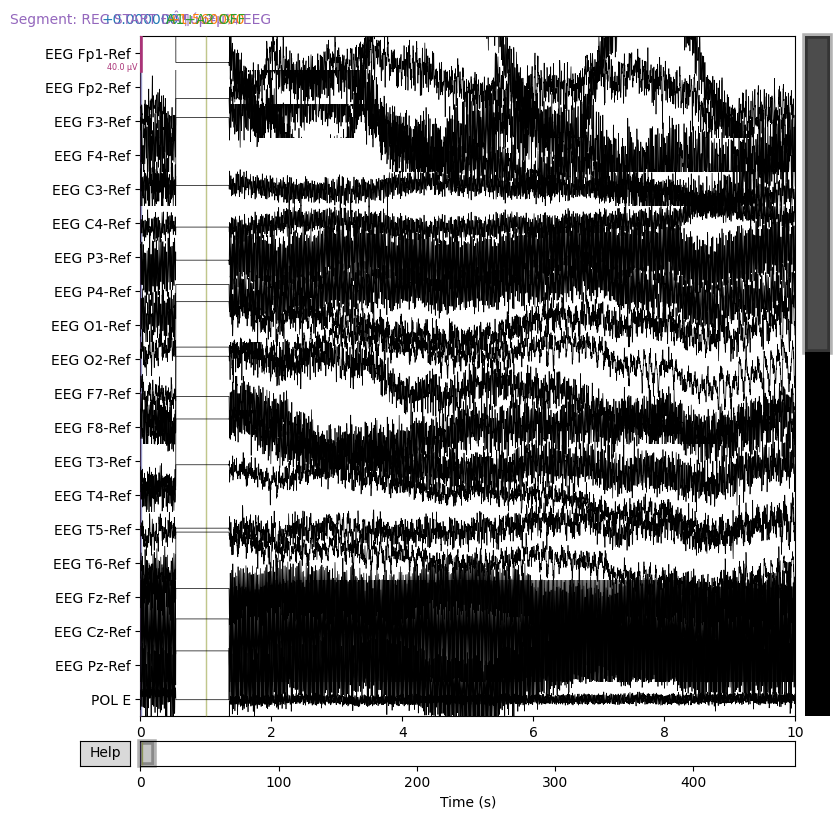

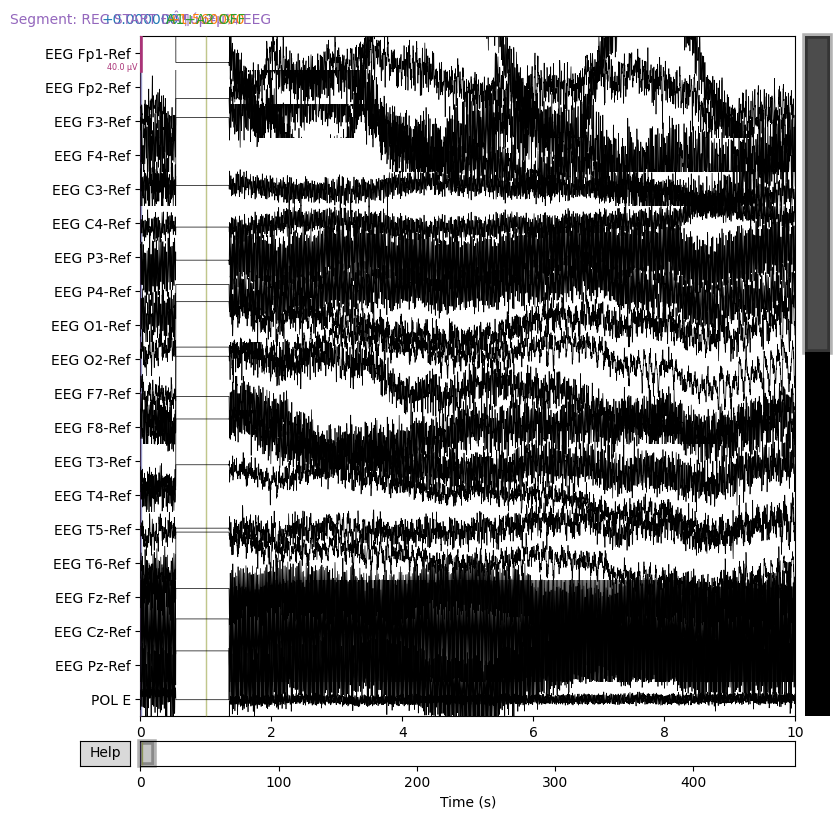

In [16]:
raw.plot()

In [17]:
raw.ch_names

['EEG Fp1-Ref',
 'EEG Fp2-Ref',
 'EEG F3-Ref',
 'EEG F4-Ref',
 'EEG C3-Ref',
 'EEG C4-Ref',
 'EEG P3-Ref',
 'EEG P4-Ref',
 'EEG O1-Ref',
 'EEG O2-Ref',
 'EEG F7-Ref',
 'EEG F8-Ref',
 'EEG T3-Ref',
 'EEG T4-Ref',
 'EEG T5-Ref',
 'EEG T6-Ref',
 'EEG Fz-Ref',
 'EEG Cz-Ref',
 'EEG Pz-Ref',
 'POL E',
 'POL PG1',
 'POL PG2',
 'EEG A1-Ref',
 'EEG A2-Ref',
 'POL T1',
 'POL T2',
 'POL X1',
 'POL X2',
 'POL X3',
 'POL X4',
 'POL X5',
 'POL X6',
 'POL X7',
 'POL SpO2',
 'POL EtCO2',
 'POL DC03',
 'POL DC04',
 'POL DC05',
 'POL DC06',
 'POL Pulse',
 'POL CO2Wave',
 'POL $A1',
 'POL $A2']

In [25]:
a = [1,5,6,8]
if 5 in a:
    print(111)

111


In [28]:
import numpy as np
regions = {
    "prefrontal": [0, 1, 2, 3, 10, 11, 16],
    "central": [4, 5, 17],
    "temporal": [12, 13, 14, 15],
    "parietal": [6, 7, 18],
    "occipital": [8, 9],
    "all":[]
}

# 动态获取变量值
partition = "prefrontal"
a=np.zeros([19,5])
b= np.delete(a,regions[partition],axis=0)

In [ ]:
def model_training(tensorboard, i, type, loader, neural_network, criterion, epoch=None, num_epochs=None, optimizer=None,
                   scheduler=None, device='cpu'):
    writer = tensorboard
    loss = 0
    acc = 0
    lr_list = []
    results_sum = []
    labels_test_sum = []
    results_PR_sum = []

    for step, (data, labels) in enumerate(loader):
        data, labels = data.to(device), labels.to(device)

        # 前向传播
        outputs = neural_network(data)
        loss_step = criterion(outputs, labels)

        if type == 'train':
            # 反向传播
            optimizer.zero_grad()
            loss_step.backward()
            optimizer.step()

        acc += outputs.argmax(dim=1).eq(labels).float().mean().item()
        loss += loss_step.item()

        if type == 'test':
            results_sum.extend(outputs.argmax(dim=1).cpu().numpy())
            labels_test_sum.extend(labels.cpu().numpy())
            results_PR_sum.extend(outputs.detach().cpu().numpy())

    acc_average = acc / (step + 1)
    loss_average = loss / (step + 1)

    if type == 'train':
        writer.add_scalars(f'{type}_metrics', {f'{type}_loss_{i}': loss_average, f'{type}_accuracy_{i}': acc_average}, epoch + 1)
        print(f"Epoch: [{epoch + 1}/{num_epochs}] Train loss: {loss_average:.4f} Train accuracy: {acc_average:.4f}")
        return neural_network, optimizer

    if type == 'validation':
        if scheduler:
            scheduler.step()
        lr_list.append(optimizer.param_groups[0]['lr'])
        writer.add_scalars(f'{type}_metrics', {f'{type}_loss_{i}': loss_average, f'{type}_accuracy_{i}': acc_average}, epoch + 1)
        print(f"Validation loss: {loss_average:.4f} Validation accuracy: {acc_average:.4f}")
        return optimizer, lr_list

    if type == 'test':
        print(f"第{i + 1}次训练测试集准确率: {acc_average:.4f}")
        return acc_average, np.array(results_sum), np.array(labels_test_sum), results_PR_sum


In [ ]:
import torch
# 实例化 STCGRU 模型
import model as dl
model = dl.STCGRU(19)

# 创建测试张量
batch_size = 64
electrodes = 19
time_points = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 使用随机值填充测试张量
test_tensor = torch.randn(batch_size, electrodes, time_points).to(device)
print("Test tensor shape:", test_tensor.shape)  # 应该是 [1, 19, 1280]

# 设置模型为评估模式（对于某些层如Dropout或BatchNorm很重要）
# model.eval()

# 确保模型也在相同的设备上
model.to(device)

# 前向传播
output = model(test_tensor)
print("Output shape:", output.shape)
output